In [1]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from six.moves import range
import os

import logging
logging.basicConfig(level=logging.DEBUG)
logging.disabled=True
import sys
#sys.stdout = sys.stderr
# Prevent reaching to maximum recursion depth in `theano.tensor.grad`
#sys.setrecursionlimit(2 ** 20)

import numpy as np
np.random.seed(2 ** 10)

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, AveragePooling2D, BatchNormalization, Dropout, Input, Activation, Add, Dense, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
import tensorflow as tf
import os

def mk_dir(dir):
    try:
        os.mkdir( dir )
    except OSError:
        # dir already exists
        pass

DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7


In [2]:
# ================================================
# DATA CONFIGURATION:
logging.debug("Loading data...")

nb_classes = 10
image_size = 32

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# convert class vectors to binary class matrices
Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)
# ================================================

# ================================================
# NETWORK/TRAINING CONFIGURATION:
logging.debug("Loading network/training configuration...")

depth = 28             # table 5 on page 8 indicates best value (4.17) CIFAR-10
k = 10                  # 'widen_factor'; table 5 on page 8 indicates best value (4.17) CIFAR-10
dropout_probability = 0 # table 6 on page 10 indicates best value (4.17) CIFAR-10

weight_decay = 0.0005   # page 10: "Used in all experiments"

batch_size = 128        # page 8: "Used in all experiments"
# Regarding nb_epochs, lr_schedule and sgd, see bottom page 10:
nb_epochs = 200
lr_schedule = [60, 120, 160] # epoch_step
def schedule(epoch_idx):
    if (epoch_idx + 1) < lr_schedule[0]:
        return 0.1
    elif (epoch_idx + 1) < lr_schedule[1]:
        return 0.02 # lr_decay_ratio = 0.2
    elif (epoch_idx + 1) < lr_schedule[2]:
        return 0.004
    return 0.0008
sgd = SGD(lr=0.1, momentum=0.9, nesterov=True)

# Other config from code; throughtout all layer:
use_bias = False        # following functions 'FCinit(model)' and 'DisableBias(model)' in utils.lua
weight_init="he_normal" # follows the 'MSRinit(model)' function in utils.lua

# Keras specific
# if K.image_data_format() == "th":
#     logging.debug("image_dim_ordering = 'th'")
channel_axis = 1
#     input_shape = (3, image_size, image_size)
# else:
#     logging.debug("image_dim_ordering = 'tf'")
#     channel_axis = -1
#     input_shape = (image_size, image_size, 3)
input_shape = (32,32,3)
# ================================================

# ================================================
# OUTPUT CONFIGURATION:
print_model_summary = True
save_model = True
save_model_plot = False

MODEL_PATH = os.environ.get('MODEL_PATH', './models/')
CHECKPOINT_PATH = os.environ.get('CHECKPOINT_PATH', './checkpoints/')
# ================================================


# Wide residual network http://arxiv.org/abs/1605.07146
def _wide_basic(n_input_plane, n_output_plane, stride):
    def f(net):
        # format of conv_params:
        #               [ [nb_col="kernel width", nb_row="kernel height",
        #               subsample="(stride_vertical,stride_horizontal)",
        #               border_mode="same" or "valid"] ]
        # B(3,3): orignal <<basic>> block
        conv_params = [ [3,3,stride,"same"],
                        [3,3,(1,1),"same"] ]
        
        n_bottleneck_plane = n_output_plane

        # Residual block
        for i, v in enumerate(conv_params):
            if i == 0:
                if n_input_plane != n_output_plane:
                    net = BatchNormalization(axis=channel_axis)(net)
                    net = Activation("relu")(net)
                    convs = net
                else:
                    convs = BatchNormalization(axis=channel_axis)(net)
                    convs = Activation("relu")(convs)
                convs = Conv2D(n_bottleneck_plane, 
                               (v[0],v[1]),
                                strides=v[2],
                                padding=v[3],
                                kernel_initializer=weight_init,
                                kernel_regularizer=l2(weight_decay),
                                use_bias=use_bias)(convs)
            else:
                convs = BatchNormalization(axis=channel_axis)(convs)
                convs = Activation("relu")(convs)
                if dropout_probability > 0:
                   convs = Dropout(dropout_probability)(convs)
                convs = Conv2D(n_bottleneck_plane, 
                               (v[0],v[1]),
                                strides=v[2],
                                padding=v[3],
                                kernel_initializer=weight_init,
                                kernel_regularizer=l2(weight_decay),
                                use_bias=use_bias)(convs)

        # Shortcut Conntection: identity function or 1x1 convolutional
        #  (depends on difference between input & output shape - this
        #   corresponds to whether we are using the first block in each
        #   group; see _layer() ).
        if n_input_plane != n_output_plane:
            shortcut = Conv2D(n_output_plane, 
                              (1,1),
                              strides=stride,
                              padding="same",
                              kernel_initializer=weight_init,
                              kernel_regularizer=l2(weight_decay),
                              use_bias=use_bias)(net)
        else:
            shortcut = net

        return Add()([convs, shortcut])
    
    return f


# "Stacking Residual Units on the same stage"
def _layer(block, n_input_plane, n_output_plane, count, stride):
    def f(net):
        net = block(n_input_plane, n_output_plane, stride)(net)
        for i in range(2,int(count+1)):
            net = block(n_output_plane, n_output_plane, stride=(1,1))(net)
        return net
    
    return f


def create_model():
    logging.debug("Creating model...")
    
    assert((depth - 4) % 6 == 0)
    n = (depth - 4) / 6
    
    inputs = Input(shape=input_shape)

    n_stages=[16, 16*k, 32*k, 64*k]


    conv1 = Conv2D(n_stages[0], 
                    (3, 3), 
                    strides=1,
                    padding="same",
                    kernel_initializer=weight_init,
                    kernel_regularizer=l2(weight_decay),
                    use_bias=use_bias)(inputs) # "One conv at the beginning (spatial size: 32x32)"

    # Add wide residual blocks
    block_fn = _wide_basic
    conv2 = _layer(block_fn, n_input_plane=n_stages[0], n_output_plane=n_stages[1], count=n, stride=(1,1))(conv1)# "Stage 1 (spatial size: 32x32)"
    conv3 = _layer(block_fn, n_input_plane=n_stages[1], n_output_plane=n_stages[2], count=n, stride=(2,2))(conv2)# "Stage 2 (spatial size: 16x16)"
    conv4 = _layer(block_fn, n_input_plane=n_stages[2], n_output_plane=n_stages[3], count=n, stride=(2,2))(conv3)# "Stage 3 (spatial size: 8x8)"

    batch_norm = BatchNormalization(axis=channel_axis)(conv4)
    relu = Activation("relu")(batch_norm)
                                            
    # Classifier block
    pool = AveragePooling2D(pool_size=(8, 8), strides=(1, 1), padding="same")(relu)
    flatten = Flatten()(pool)
    predictions = Dense(units=nb_classes, kernel_initializer=weight_init, use_bias=use_bias,
                        kernel_regularizer=l2(weight_decay))(flatten)

    model = Model(inputs=inputs, outputs=predictions)
    return model



        


DEBUG:root:Loading data...
DEBUG:root:Loading network/training configuration...
C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [6]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(), loss="categorical_crossentropy", metrics=['accuracy'])

if print_model_summary:
    logging.debug("Model summary...")
    model.count_params()
    model.summary()

if save_model_plot:
    logging.debug("Saving model plot...")
    mk_dir(MODEL_PATH)
    from tensorflow.keras.utils import plot_model
    plot_model(model, to_file=os.path.join(MODEL_PATH, 'WRN-{0}-{1}.png'.format(depth, k)), show_shapes=True)



mk_dir(CHECKPOINT_PATH)
callbacks = [ LearningRateScheduler(schedule=schedule),
              ModelCheckpoint(CHECKPOINT_PATH+'/WRN_{epoch:02d}-{val_loss:.2f}.hdf5',
                     monitor='val_loss',
                     verbose=1,
                     save_best_only=True,
                     mode='auto')
            ]


# logging.debug("Running training...")
# # fit the model on the batches generated by train_datagen.flow()
# model.fit(train_datagen.flow(X_train, Y_train, batch_size=batch_size, shuffle=True),
#                     steps_per_epoch=X_train.shape[0]/batch_size,   
#                     epochs=nb_epochs,
#                     validation_data=test_datagen.flow(X_test, Y_test, batch_size=batch_size),
#                     callbacks=callbacks)

# if save_model:
#     logging.debug("Saving model...")
#     mk_dir(MODEL_PATH)
#     model.save(os.path.join(MODEL_PATH, 'WRN-{0}-{1}.h5'.format(depth, k)), overwrite=True)

DEBUG:root:Creating model...
DEBUG:root:Model summary...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   432         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 16)   0           ['batch_normalization[0][0]']

DEBUG:root:Creating ImageDataGenerators...
C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\keras_preprocessing\image\image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


In [3]:
import tensorflow as tf
import tensorflow.keras as keras
# Model / data parameters
num_classes = 10
batch_size = 32
input_shape = (32, 32, 1)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(x_train.shape)
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test= keras.utils.to_categorical(y_test, num_classes)
    
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
train_ds = (train_ds
                .shuffle(buffer_size=15000,seed=42,reshuffle_each_iteration=False)
                .batch(batch_size=batch_size, drop_remainder=False))

test_ds = (test_ds
                .batch(batch_size=batch_size, drop_remainder=False))
print(train_ds)


(50000, 32, 32, 3)
<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


In [10]:

model.evaluate(X_test, y_test)


313/313 [==============================] - 15s 46ms/step - loss: 707.9358 - accuracy: 0.1005


[707.935791015625, 0.10050000250339508]

In [6]:
model = tf.keras.models.load_model("./checkpoints/WRN_base.hdf5")
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_84 (Conv2D)             (None, 32, 32, 16)   432         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_75 (BatchN  (None, 32, 32, 16)  64          ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_75 (Activation)     (None, 32, 32, 16)   0           ['batch_normalization_75[0]

In [7]:
# model.summary()
model.evaluate(test_ds)

313/313 [==============================] - 17s 44ms/step - loss: 1.4234 - accuracy: 0.7352


[1.423370122909546, 0.7351999878883362]

In [14]:
# model.summary()
model.evaluate(test_ds)

313/313 [==============================] - 14s 44ms/step - loss: 1.4787 - accuracy: 0.7284


[1.4786548614501953, 0.7283999919891357]

In [15]:

# earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)

# model = keras.models.load_model("./models/cifaroutlier_EDL_adam.hdf5",custom_objects={"custom_loss_function":loss})
# model = tf.keras.models.load_model("./checkpoints/WRN_base.hdf5")
model.compile(optimizer=tf.keras.optimizers.Adam(), loss="categorical_crossentropy", metrics=['accuracy'])

# history = model.fit(train_ds, validation_data=validation_ds, epochs=30,callbacks=[lambda_callback,earlyStop])
model.fit(train_ds,validation_data=test_ds, epochs =30, callbacks=[earlyStop])

Epoch 1/30
1563/1563 [==============================] - 250s 158ms/step - loss: 1.5869 - accuracy: 0.7471 - val_loss: 2.0641 - val_accuracy: 0.5381
Epoch 2/30
1563/1563 [==============================] - 247s 158ms/step - loss: 1.2743 - accuracy: 0.7781 - val_loss: 1.7718 - val_accuracy: 0.5990
Epoch 3/30
1563/1563 [==============================] - 247s 158ms/step - loss: 1.1042 - accuracy: 0.7999 - val_loss: 1.2812 - val_accuracy: 0.7332
Epoch 4/30
1563/1563 [==============================] - 247s 158ms/step - loss: 1.0018 - accuracy: 0.8174 - val_loss: 1.1655 - val_accuracy: 0.7568
Epoch 5/30
1563/1563 [==============================] - 246s 157ms/step - loss: 0.9244 - accuracy: 0.8328 - val_loss: 1.2525 - val_accuracy: 0.7270
Epoch 6/30
1563/1563 [==============================] - 245s 157ms/step - loss: 0.8625 - accuracy: 0.8453 - val_loss: 1.0712 - val_accuracy: 0.7773
Epoch 7/30
1563/1563 [==============================] - 245s 157ms/step - loss: 0.8142 - accuracy: 0.8580 - val_

In [16]:
model.fit(train_ds,validation_data=test_ds, epochs =30, callbacks=[earlyStop])
model.evaluate(test_ds)

Epoch 1/30
1563/1563 [==============================] - 243s 155ms/step - loss: 0.6584 - accuracy: 0.9049 - val_loss: 1.1817 - val_accuracy: 0.7633
Epoch 2/30
1563/1563 [==============================] - 243s 155ms/step - loss: 0.6380 - accuracy: 0.9076 - val_loss: 1.1863 - val_accuracy: 0.7798
Epoch 3/30
1563/1563 [==============================] - 243s 155ms/step - loss: 0.6329 - accuracy: 0.9090 - val_loss: 1.3115 - val_accuracy: 0.7333
Epoch 4/30
1563/1563 [==============================] - 243s 155ms/step - loss: 0.6235 - accuracy: 0.9116 - val_loss: 1.0728 - val_accuracy: 0.8081
Epoch 5/30
1563/1563 [==============================] - 243s 155ms/step - loss: 0.6137 - accuracy: 0.9156 - val_loss: 1.1162 - val_accuracy: 0.7850
Epoch 6/30
1563/1563 [==============================] - 243s 155ms/step - loss: 0.6061 - accuracy: 0.9191 - val_loss: 1.0382 - val_accuracy: 0.8057
Epoch 7/30
1563/1563 [==============================] - 243s 155ms/step - loss: 0.6072 - accuracy: 0.9175 - val_

In [17]:
model.fit(train_ds,validation_data=test_ds, epochs =30, callbacks=[earlyStop])
model.evaluate(test_ds)

Epoch 1/30
1563/1563 [==============================] - 243s 155ms/step - loss: 0.6096 - accuracy: 0.9186 - val_loss: 1.0274 - val_accuracy: 0.8118
Epoch 2/30
1563/1563 [==============================] - 243s 155ms/step - loss: 0.6049 - accuracy: 0.9174 - val_loss: 1.0795 - val_accuracy: 0.7998
Epoch 3/30
1563/1563 [==============================] - 243s 155ms/step - loss: 0.6008 - accuracy: 0.9192 - val_loss: 1.1686 - val_accuracy: 0.7819
Epoch 4/30
1563/1563 [==============================] - 243s 155ms/step - loss: 0.5947 - accuracy: 0.9206 - val_loss: 1.0865 - val_accuracy: 0.7960
Epoch 5/30
313/313 [==============================] - 14s 43ms/step - loss: 1.0274 - accuracy: 0.8118


[1.0274261236190796, 0.8118000030517578]

In [18]:
model.save("./models/wideresnet_.81.hdf5")

DEBUG:h5py._conv:Creating converter from 5 to 3


In [9]:
# Model / data parameters
from tensorflow import keras
num_classes = 10
batch_size = 32
input_shape = (32, 32, 1)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
    
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
train_ds = (train_ds
                .shuffle(buffer_size=15000,seed=42,reshuffle_each_iteration=False)
                .batch(batch_size=batch_size, drop_remainder=False))

test_ds = (test_ds
                .batch(batch_size=batch_size, drop_remainder=False))
print(train_ds)

# Model / data parameters
num_classes = 100
batch_size = 32
input_shape = (32, 32, 1)
(x_train100, y_train100), (x_test100, y_test100) = tf.keras.datasets.cifar100.load_data(label_mode="fine")
print(x_train100.shape)
# convert class vectors to binary class matrices
y_train100 = keras.utils.to_categorical(y_train100, num_classes)
y_test100 = keras.utils.to_categorical(y_test100, num_classes)
    
train_ds100 = tf.data.Dataset.from_tensor_slices((x_train100, y_train100))
test_ds100 = tf.data.Dataset.from_tensor_slices((x_test100, y_test100))
train_ds100 = (train_ds100
                .shuffle(buffer_size=15000,seed=42,reshuffle_each_iteration=False)
                .batch(batch_size=batch_size, drop_remainder=False))

test_ds100 = (test_ds100
                .batch(batch_size=batch_size, drop_remainder=False))
print(train_ds100)




<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
(50000, 32, 32, 3)
<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>


In [ ]:
model.evaluate(test_ds)

In [31]:
class lambda_update(tf.keras.callbacks.Callback):
    def __init__(self, annealing_max,  lambda_t=0, max_t=1):
        self.start_val = tf.Variable(initial_value=lambda_t, dtype=tf.float32) 
        
        self.lambda_t = tf.Variable(initial_value=lambda_t, dtype=tf.float32) #updates each epoch
        self.max_t = tf.Variable(initial_value=max_t, dtype=tf.float32)
        self.annealing_max = tf.Variable(initial_value=annealing_max, dtype=tf.float32)

    def on_epoch_begin(self, epoch, logs={}): #needs to be on begin, otherwise the epoch update won't increase the value from 0 to 0.1 till the 3rd epoch...
        val = tf.reduce_min([self.max_t, tf.cast(epoch+self.start_val, tf.dtypes.float32) / tf.cast(self.annealing_max, tf.dtypes.float32)])
        tf.print("annealing coef updated to:", val)
        self.lambda_t.assign(val)
        
def MAEBM(lambda_callback: lambda_update):
    import tensorflow_probability as tfp
    def MAEBM_loss(labels, outputs):
        n_classes=10
        evidence = tf.exp(outputs)
        # print("evidence",evidence)
        # evidence = exp_evidence(outputs)
        alpha = evidence + 1
        # print(alpha)
        # soft_output = tf.one_hot(labels, n_classes)
        soft_output= labels
        # print("soft_output",soft_output)
        S = tf.reduce_sum(alpha,axis=1,keepdims=True)
        # print("S",S)
        alpha_0 = S * tf.ones((outputs.shape[-1]))
        # print("alpha_0",alpha_0)
        UCE_loss = tf.reduce_mean(
            tf.cast(soft_output,dtype=tf.float32) * (tf.compat.v1.digamma(alpha_0) - tf.compat.v1.digamma(alpha))
        )
        # print("UCE_loss_1",UCE_loss)
        # annealing_coef =  lambda_callback.lambda_t
        # dirichlet_weight = annealing_coef * tf.reduce_mean(-tfp.distributions.Dirichlet(alpha).entropy())
        dirichlet_weight= 0
        # print("dr",dirichlet_weight)
        UCE_loss = (
            UCE_loss + dirichlet_weight
        )

        return UCE_loss
    return MAEBM_loss

In [54]:
model = tf.keras.models.load_model("./checkpoints/WRN_07-1.42.hdf5")


model2= Model(inputs=model.input, outputs=model.layers[-2].output)
x = model2.layers[-1].output
predictions = Dense(units=nb_classes, name="output")(x)
model= Model(inputs=model2.inputs, outputs=predictions)
print(model.outputs)
# model.summary()
# model.evaluate(test_ds)
# model = create_model()
# model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=['accuracy'])
# callbacks = [ LearningRateScheduler(schedule=schedule),
#               ModelCheckpoint(CHECKPOINT_PATH+'/WRN_{epoch:02d}-{val_loss:.2f}.hdf5',
#                      monitor='val_loss',
#                      verbose=1,
#                      save_best_only=True,
#                      mode='auto')
#             ]
# logging.debug("Running training...")
# fit the model on the batches generated by train_datagen.flow()
# model.fit(train_ds,epochs = 20, validation_data=test_ds, callbacks=callbacks)

# model.save('./models/cifaroutlier_EDL_adam.hdf5')
lambda_callback = lambda_update(100,0,max_t = .01)
loss = MAEBM(lambda_callback)
# # loss = keras.losses.CategoricalCrossentropy(from_logits=True)


# mk_dir(CHECKPOINT_PATH)
# callbacks = [ LearningRateScheduler(schedule=schedule),
#               ModelCheckpoint(CHECKPOINT_PATH+'/Energy_{epoch:02d}-{val_loss:.2f}.hdf5',
#                      monitor='val_loss',
#                      verbose=1,
#                      save_best_only=True,
#                      mode='auto'),
#               lambda_callback
#             ]


# earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=10,restore_best_weights=True)

# model = keras.models.load_model("./models/cifaroutlier_EDL_adam.hdf5",custom_objects={"custom_loss_function":loss})
# model = keras.models.load_model("./models/cifaroutlier_blank.hdf5")
model.compile(optimizer='adam',
              loss=loss,
              metrics=['accuracy'])
# model.compile( loss="categorical_crossentropy", metrics=['accuracy'])
# history = model.fit(train_ds, validation_data=validation_ds, epochs=30,callbacks=[lambda_callback,earlyStop])
model.fit(train_ds,epochs = 20, validation_data=test_ds)#, callbacks=callbacks)

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'output')>]
Epoch 1/20
1563/1563 [==============================] - 250s 158ms/step - loss: 0.2633 - accuracy: 0.5357 - val_loss: 0.7751 - val_accuracy: 0.1573
Epoch 2/20
 224/1563 [===>..........................] - ETA: 3:20 - loss: 0.2081 - accuracy: 0.6080

KeyboardInterrupt: 

In [10]:
from scipy.special import gammaln, digamma
def dirichlet_prior_network_uncertainty(logits, epsilon=1e-10, alpha_correction=True):
    """
    :param logits:
    :param epsilon:
    :return:
    """
    logits = np.asarray(logits, dtype=np.float64)
    alphas = np.exp(logits)
    alphas = np.clip(alphas, 0, np.finfo(np.dtype("float32")).max)
    if alpha_correction:
        alphas = alphas + 1
    alpha0 = np.sum(alphas, axis=1, keepdims=True)
    probs = alphas / alpha0

    conf = np.max(probs, axis=1)

    entropy_of_exp = -np.sum(probs * np.log(probs + epsilon), axis=1)
    expected_entropy = -np.sum(
        (alphas / alpha0) * (digamma(alphas + 1) - digamma(alpha0 + 1.0)), axis=1
    )

    mutual_info = entropy_of_exp - expected_entropy

    epkl = np.squeeze((alphas.shape[1] - 1.0) / alpha0)

    dentropy = (
        np.sum(
            gammaln(alphas) - (alphas - 1.0) * (digamma(alphas) - digamma(alpha0)),
            axis=1,
            keepdims=True,
        )
        - gammaln(alpha0)
    )

    uncertainty = {
        "confidence_alea_uncert.": np.float32(np.squeeze(conf)),
        "entropy_of_expected": -np.squeeze(entropy_of_exp),
        "expected_entropy": -np.squeeze(expected_entropy),
        "mutual_information": -np.squeeze(mutual_info),
        "EPKL": -epkl,
        "differential_entropy": -np.squeeze(dentropy),
    }
    # result = {k: torch.from_numpy(v).float() for k, v in uncertainty.items()}
    return uncertainty

In [11]:
import math
from scipy.special import logsumexp
num_classes=10
import pandas as pd

def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits/10,-10,10))

def calcEntropy_Tensors2(y_hat):
    #entropy is the sum of y * log(y) for all possible labels.
    #doesn't deal with cases of log(0)
    val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
    sumEntropies =  tf.reduce_sum(tf.boolean_mask(val,tf.math.is_finite(val)))
    return -sumEntropies


def getPredictions_Energy(model, input_set, stopping_point=None):
    # stopping_point = None
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    #     train_ds, test_ds, validation_ds = (dataset)
    Results=[]
    Pred=[]
    Labels =[]
    Uncert = []
    Outputs = pd.DataFrame()
    Energy = []
    Energy_softmax = []
    Energy_evidence = []
    Energy_alpha = []
    Energy_Mass = []
    Entropy = []
    pAcc=[]
    Calibration=[]
    
    conf=[]
    entropy_of_exp=[]
    expected_entropy=[]
    mutual_info=[]
    epkl=[]
    dentropy=[]
            
    T = 1 ### temperature variable
    for i, (x,y) in enumerate(input_set):
        if stopping_point and i > stopping_point:
            break
        print("prediction: {} of {}".format(i,len(input_set)),end='\r')
        predictions = model.predict(x)
        for j, prediction in enumerate(predictions):
            dirch = dirichlet_prior_network_uncertainty([prediction])
            # print(dirch)
            conf.append(dirch["confidence_alea_uncert."])
            entropy_of_exp.append(dirch["entropy_of_expected"])
            expected_entropy.append(dirch["expected_entropy"])
            mutual_info.append(dirch["mutual_information"])
            epkl.append(dirch["EPKL"])
            dentropy.append(dirch["differential_entropy"])
            
            evidence =exp_evidence(prediction)
            alpha = evidence +1
            S = sum(alpha)
            E = alpha - 1
            Mass = alpha / S
            u = num_classes / S
            Uncert.append(u.numpy().mean())
            Results.append(np.argmax(prediction))
            Labels.append(np.argmax(y[j]))
            Energy.append( -(logsumexp(np.array(prediction))))
            Energy_softmax.append( -(1 * logsumexp(np.array(tf.nn.softmax(prediction))/1)))
            Energy_evidence.append( -(1 * logsumexp(np.array(evidence)/1)))
            Energy_alpha.append( -(1 * logsumexp(np.array(alpha)/1)))
            Energy_Mass.append( -(1 * logsumexp(np.array(Mass)/1)))
            Entropy.append(calcEntropy_Tensors2(tf.nn.softmax(prediction)).numpy())
            Calibration.append(np.amax(tf.nn.softmax(prediction).numpy()))
    print("")
    _uncert = np.array(Uncert)
    df = pd.DataFrame({"x":Results,"y":Labels,"uncert":Uncert,"energy":Energy,"Energy_softmax":Energy_softmax,"Energy_evidence":Energy_evidence,"Energy_alpha":Energy_alpha,"Energy_Mass":Energy_Mass,
                       'entropy':Entropy,
                       'calibration':Calibration,
                        "confidence_alea_uncert":conf,
            "entropy_of_expected":entropy_of_exp,
            "expected_entropy":expected_entropy,
            "mutual_information":mutual_info,
            "EPKL":epkl,
            "differential_entropy":dentropy,
                      })
    
    conditions = [df['x'] == df['y'],df['x'] != df['y']]
    choices = [1, 0]
    df['correct'] = np.int32(np.select(conditions, choices, default=None))
    return df

In [12]:
output_ID= getPredictions_Energy(model, test_ds,stopping_point=None)
output_OOD = getPredictions_Energy(model, test_ds100,stopping_point=None)
#make sure there are no mistaken corrects in outlier data
output_OOD['correct']=0
output_OOD['outlier']=1
output_ID['outlier']=0


prediction: 312 of 313
prediction: 312 of 313


In [18]:
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)
import matplotlib.pyplot as plt
def buildCompareDistribPlot(ID,OOD=None,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"]):
        lessThanMetrics = ["energy","uncert","entropy"]
        if type(metrics ) is not list:
            metrics = [metrics]
        for i, metric in enumerate(metrics):
            # _ = plt.hist(ID[metric].tolist(), bins=100)  # arguments are passed to np.histogram
            legend = ["threshold","correct","incorrect", "OOD"]
            Correct = ID.loc[(ID['correct'] == True)]
            Incorrect = ID.loc[(ID['correct'] == False)]
            _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
            _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
            if OOD is None:
                OOD = pd.DataFrame(columns=ID.columns)
            _ = plt.hist(OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram
            # plt.title("Histogram with 'auto' bins")
            
            
            if threshold:
                if type(threshold) is list:
                    if i >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[i]
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    # _threshold = np.array(ID[metric]).mean()
                    _threshold = np.array(Correct[metric]).mean()
                if _threshold == "gmean":
                    # _threshold = np.array(ID[metric]).mean()
                    fpr, tpr, thresholds = roc_curve(np.int32(ID['correct']), ID[metric],pos_label=0)
                    gmeans = sqrt(tpr * (1-fpr))
                    ix = argmax(gmeans)
                    _threshold = thresholds[ix]
                else:
                    _threshold = np.float32(_threshold)
                plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                plt.title(metric + " outliers")
                plt.legend(legend)
                plt.xlabel("entropy")
                plt.ylabel("frequency")
                plt.show()
                if metric in lessThanMetrics: ## metrics that require less than metric
                    OOD_accepted = OOD.loc[(OOD[metric].tolist() <= _threshold)] #FP
                    OOD_rejected = OOD.loc[(OOD[metric].tolist() > _threshold)] #TN
                    ID_accepted = ID.loc[(ID[metric] <= _threshold)] #TP
                    ID_rejected = ID.loc[(ID[metric] > _threshold)] #FN
                    
                    
                    accepted_correct = Correct.loc[(Correct[metric] <= _threshold)] #TP
                    rejected_correct = Correct.loc[(Correct[metric] > _threshold)]  #FN
                    
                    accepted_incorrect = Incorrect.loc[(Incorrect[metric] <= _threshold)] #FP
                    rejected_incorrect = Incorrect.loc[(Incorrect[metric] > _threshold)] #TN
                    
                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                    print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                    print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                    print("overall Accepted acc:",(overall_accepted_acc))
                    
                    # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
                    # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
                    # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] <= _threshold)])+len(OOD.loc[(OOD[metric] <= _threshold)])))
                else: ### metrics that require greater than metric
                    OOD_accepted = OOD.loc[(OOD[metric].tolist() >= _threshold)] #FP
                    OOD_rejected = OOD.loc[(OOD[metric].tolist() < _threshold)] #TN
                    ID_accepted = ID.loc[(ID[metric] >= _threshold)] #TP
                    ID_rejected = ID.loc[(ID[metric] < _threshold)] #FN
                    
                    accepted_correct = Correct.loc[(Correct[metric] >= _threshold)] #TP
                    rejected_correct = Correct.loc[(Correct[metric] < _threshold)]  #FN
                    
                    accepted_incorrect = Incorrect.loc[(Incorrect[metric] >= _threshold)] #FP
                    rejected_incorrect = Incorrect.loc[(Incorrect[metric] < _threshold)] #TN
                    
                    
                    
                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                    print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                    print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                    print("overall Accepted acc:",(overall_accepted_acc))
                    
                    # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() >= _threshold)]), "out of ", len(OOD))
                    # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] >= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] >= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] >= _threshold)]))
                    # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] >= _threshold)])+len(OOD.loc[(OOD[metric] >= _threshold)])))
                
                print("TPR_ID-OOD",len(ID_accepted)/(len(ID_accepted) + len(ID_rejected)))
                print("TPR_acc",len(accepted_correct)/(len(accepted_correct) + len(rejected_correct)))
                if len(OOD) > 0:
                    print("FPR_ID-OOD",len(OOD_accepted)/(len(OOD_accepted) + len(OOD_rejected)))
                else: 
                    print("FPR for OOD is div by zero, was OOD included?")
                print("FPR_acc",len(accepted_incorrect)/(len(accepted_incorrect) + len(rejected_incorrect)))

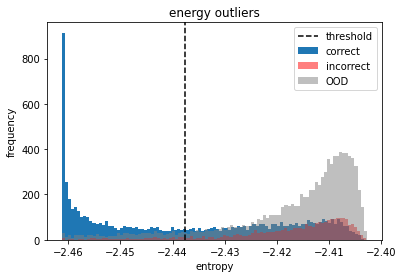

OOD accepted: 967 : with threshold: -2.4375856
ID accepted: 4032 :with acc: 0.9459325396825397
overall Accepted acc: 0.7629525905181036
TPR_ID-OOD 0.4032
TPR_acc 0.5187704026115343
FPR_ID-OOD 0.0967
FPR_acc 0.0823262839879154


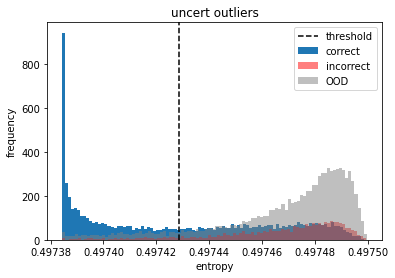

OOD accepted: 1000 : with threshold: 0.49742845
ID accepted: 4096 :with acc: 0.9443359375
overall Accepted acc: 0.7590266875981162
TPR_ID-OOD 0.4096
TPR_acc 0.5261153427638737
FPR_ID-OOD 0.1
FPR_acc 0.08610271903323263


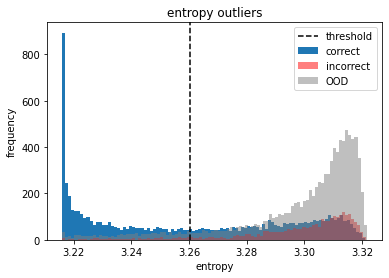

OOD accepted: 942 : with threshold: 3.2604463
ID accepted: 3983 :with acc: 0.9470248556364549
overall Accepted acc: 0.7658883248730964
TPR_ID-OOD 0.3983
TPR_acc 0.5130576713819369
FPR_ID-OOD 0.0942
FPR_acc 0.07968277945619336


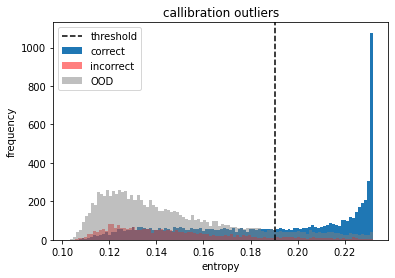

OOD accepted: 1165 : with threshold: 0.1902908
ID accepted: 4352 :with acc: 0.9377297794117647
overall Accepted acc: 0.7397136124705456
TPR_ID-OOD 0.4352
TPR_acc 0.5550870511425462
FPR_ID-OOD 0.1165
FPR_acc 0.10234138972809667


In [19]:
buildCompareDistribPlot(output_ID, output_OOD, ["energy",'uncert','entropy','calibration'], "mean")

OOD size 10000
energy AUC 0.26438845 G-Mean=0.6730791483919257, TPR=0.7082, FPR=0.3603
entropy AUC 0.26473565 G-Mean=0.6723370137066679, TPR=0.7083, FPR=0.3618
uncert AUC 0.264035435 G-Mean=0.6729177141374716, TPR=0.7015, FPR=0.3545
confidence_alea_uncert AUC 0.731340355 G-Mean=0.6659280441609289, TPR=0.6292, FPR=0.2952
entropy_of_expected AUC 0.7351157349999999 G-Mean=0.6719096144571828, TPR=0.6401, FPR=0.2947
expected_entropy AUC 0.734915365 G-Mean=0.6719348182673673, TPR=0.636, FPR=0.2901
calibration AUC 0.731295535 G-Mean=0.6658111969620216, TPR=0.6305, FPR=0.2969


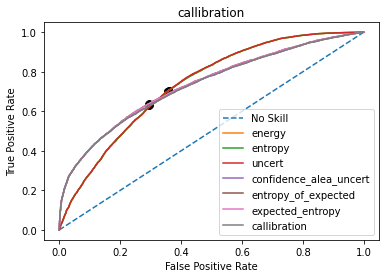

[-2.4192708, 3.2950273, 0.49746305, 0.13043724, -2.2971238854442038, -2.1032494945101825, 0.15725592]


In [60]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from numpy import sqrt
from numpy import argmax
# metrics =["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"]
# metrics =['energy','uncert','expected_entropy','calibration']

metrics = ["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"]
def calc_auc_OOD(ID,OOD,metrics=['energy'],OOD_rate=[.1,.2,.5,1], plot=False):
    points = []
    # OOD_rate = [0,.1,.2,.5,1]
    _output_ID = ID
    _output_OOD = OOD

    _output_ID["outlier"]=1
    _output_OOD["outlier"]=0
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    for i in OOD_rate:
        # print(int(min((len(_output_ID) * i),len(_output_ID))))
        _OOD = _output_OOD.iloc[0:int(min((len(_output_ID) * i),len(_output_ID)))]
        print("OOD size",len(_OOD))
        _df = pd.concat([_output_ID,_OOD], ignore_index=True)
        y_true = np.int32(_df['outlier'])

    #     print(len(_df))
    #     for metric in metrics:
    #         points.append([])
    #         # print(metric, ":", average_precision_score(y_true, _df[metric]))

    #         Correct = _df.loc[(_df['correct'] == True)]
    #         Incorrect = _df.loc[(_df['correct'] == False)]
    #         fpr, tpr, thresholds = roc_curve(np.int32(_output_ID['correct']), _output_ID[metric],pos_label=1)
    #         gmeans = sqrt(tpr * (1-fpr))
    #         ix = argmax(gmeans)
    #         _threshold = thresholds[ix]
    #         # _threshold = np.array(Correct[metric]).mean()
        plots = []
        for metric in metrics:    
            lr_auc = roc_auc_score(y_true, _df[metric])
            # print("lr_auc",lr_auc)
            if metric in lessThanMetrics:
                pos_label = 0
            else:
                pos_label = 1
            fpr, tpr, thresholds = roc_curve(y_true, _df[metric],pos_label=pos_label)
            gmeans = sqrt(tpr * (1-fpr))
            # print(gmeans)
            # locate the index of the largest g-mean
            ix = argmax(gmeans)
            threshold = thresholds[ix]
            print(metric ,"AUC",lr_auc,'G-Mean={}, TPR={}, FPR={}'.format(gmeans[ix],tpr[ix],fpr[ix]))
            _thresholds.append(threshold)
            # plot the roc curve for the model
            plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
        # if plot:
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            plt.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            plt.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(metric)
        plt.legend()
        # show the plot
        plt.show()
        return _thresholds
# calc_auc_OOD(output_ID,output_OOD_svhn,metrics=metrics,OOD_rate=[1])       

thresholds = calc_auc_OOD(output_ID,output_OOD,metrics=metrics,OOD_rate=[1])       
print(thresholds)


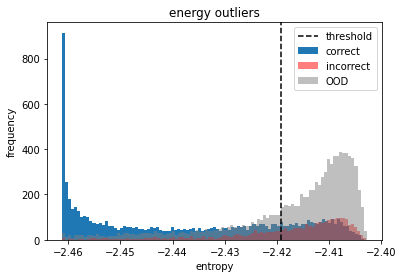

OOD accepted: 2919 : with threshold: -2.4192708
ID accepted: 6397 :with acc: 0.8666562451148976
overall Accepted acc: 0.5951051953628167
TPR_ID-OOD 0.6397
TPR_acc 0.7540805223068553
FPR_ID-OOD 0.2919
FPR_acc 0.3221299093655589


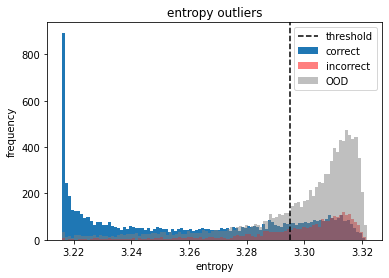

OOD accepted: 2918 : with threshold: 3.2950273
ID accepted: 6382 :with acc: 0.8675963647759323
overall Accepted acc: 0.5953763440860215
TPR_ID-OOD 0.6382
TPR_acc 0.7531284004352558
FPR_ID-OOD 0.2918
FPR_acc 0.31910876132930516


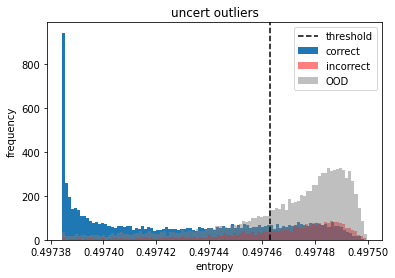

OOD accepted: 2989 : with threshold: 0.49746305
ID accepted: 6457 :with acc: 0.8635589282948738
overall Accepted acc: 0.5903027736608089
TPR_ID-OOD 0.6457
TPR_acc 0.7584330794341676
FPR_ID-OOD 0.2989
FPR_acc 0.33270392749244715


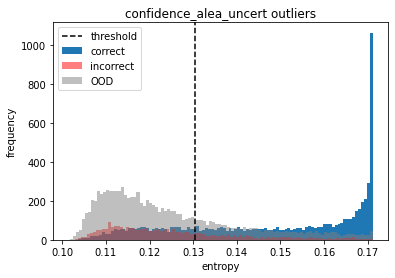

OOD accepted: 2952 : with threshold: 0.13043724
ID accepted: 6292 :with acc: 0.8768277177368087
overall Accepted acc: 0.5968195586326266
TPR_ID-OOD 0.6292
TPR_acc 0.7504080522306855
FPR_ID-OOD 0.2952
FPR_acc 0.2926737160120846


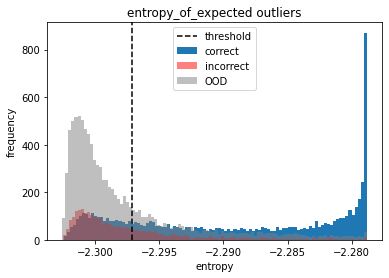

OOD accepted: 2947 : with threshold: -2.297124
ID accepted: 6401 :with acc: 0.8673644743008905
overall Accepted acc: 0.5939238339751819
TPR_ID-OOD 0.6401
TPR_acc 0.7551686615886833
FPR_ID-OOD 0.2947
FPR_acc 0.32061933534743203


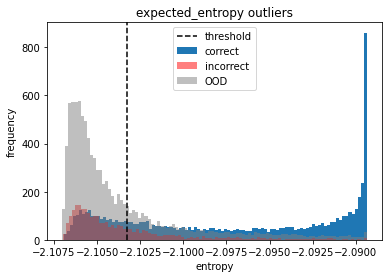

OOD accepted: 2901 : with threshold: -2.1032495
ID accepted: 6360 :with acc: 0.8693396226415094
overall Accepted acc: 0.5970197602850664
TPR_ID-OOD 0.636
TPR_acc 0.7520402611534276
FPR_ID-OOD 0.2901
FPR_acc 0.313821752265861


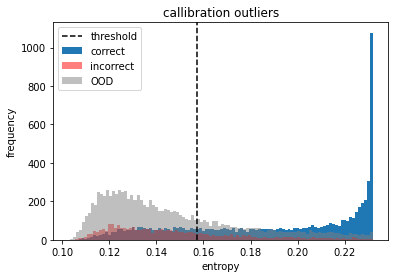

OOD accepted: 2969 : with threshold: 0.15725592
ID accepted: 6305 :with acc: 0.8766058683584457
overall Accepted acc: 0.5959672201854648
TPR_ID-OOD 0.6305
TPR_acc 0.7517682263329706
FPR_ID-OOD 0.2969
FPR_acc 0.2938066465256798


In [56]:
buildCompareDistribPlot(output_ID, output_OOD, metrics, thresholds)